# Gibbs sampling on random multivariate Gaussians.

In [ ]:
import sys
from copy import copy
import itertools as it, functools as ft
from collections import OrderedDict as ordict, defaultdict as ddict
import numpy as np
import scipy.stats as scs
from scipy.interpolate import griddata

In [68]:
class Gaussian(object):
    def __init__(self, mean=None, covariance=None, eigenvectors=None, eigenvalues=None, ndim=None):
        if covariance is None:
            if eigenvectors is None or eigenvalues is None:
                raise ValueError()
        else:
            if eigenvectors is not None or eigenvalues is not None:
                raise ValueError()
            eigenvalues, eigenvectors = np.linalg.eigh(covariance)
        if ndim is None:
            ndim = len(mean) if mean is not None else len(eigenvalues)
        self.mean = np.zeros((ndim,)) if mean is None else np.array(mean, dtype=float)
        self.eigenvalues = np.ones((ndim,)) if eigenvalues is None else np.array(eigenvalues, dtype=float)
        self.eigenvectors = np.identity(ndim) if eigenvectors is None else np.array(eigenvectors, dtype=float)
        assert self.mean.shape == (ndim,)
        assert self.eigenvalues.shape == (ndim,)
        assert self.eigenvectors.shape == (ndim, ndim)
        if not (self.eigenvalues > 0).all():
            raise ValueError("covariance must be positive definite")

    @property
    def ndim(self):
        return len(self.mean)

    @property
    def covariance(self):
        return np.einsum("ij,j,jk->ik", self.eigenvectors, self.eigenvalues,
                         self.eigenvectors.T, optimize=True)

    def distance(self, x):
        return np.einsum("...i,ij,j,jk,...k->...",
                         x - self.mean, self.eigenvectors,
                         1 / self.eigenvalues,
                         self.eigenvectors.T, x - self.mean,
                         optimize=True)

    def pdf(self, x):
        return self.pdf_from_z(self.distance(x))

    def pdf_from_z(self, z):
        return np.exp(-0.5 * z) / np.sqrt(np.prod(2 * np.pi * self.eigenvalues))

    def projection(self, proj):
        projected_mean = np.dot(proj, self.mean)
        projected_covariance = np.einsum("ij,jk,k,kl,lm->im", proj, self.eigenvectors, self.eigenvalues, self.eigenvectors.T, proj.T)
        return Gaussian(mean=projected_mean, covariance=projected_covariance)

    def conditional(self, value, cond, pred):
        # [x, y]T ~ N([a, b]T, [[A, C], [CT, B]])
        # => x|y ~ N(a + C B-1 (y-b), A - C B-1 CT)

        pred_covar  = np.dot(pred, np.dot(self.covariance, pred.T))
        cond_covar  = np.dot(cond, np.dot(self.covariance, cond.T))
        cross_covar = np.dot(pred, np.dot(self.covariance, cond.T))

        pred_mean = np.dot(pred, self.mean)
        cond_mean = np.dot(cond, self.mean)
        cond_value = np.dot(cond, value)

        #print "c", cond.shape, "p", pred.shape
        #print "cx", cond_covar.shape, "px", pred_covar.shape, "xx", cross_covar.shape
        #print "cm", cond_mean.shape, "pm", pred_mean.shape

        mean = pred_mean + np.dot(cross_covar,
                                  np.linalg.solve(cond_covar,
                                                  cond_value - cond_mean))
        covariance = pred_covar - np.dot(cross_covar,
                                         np.linalg.solve(cond_covar,
                                                         cross_covar.T))
        return Gaussian(mean=mean, covariance=covariance)

    @staticmethod
    def product(models):
        invcovar = sum(np.einsum("ij,j,jk->ik",
                                 model.eigenvectors, 1 / model.eigenvalues, model.eigenvectors.T,
                                 optimize=True)
                       for model in models)
        eigenvalues, eigenvectors = np.linalg.eigh(invcovar)
        eigenvalues = 1 / eigenvalues
        eigenvectors = eigenvectors.T

        mean = np.einsum("ij,j,jk,k->i", eigenvectors, eigenvalues, eigenvectors.T,
                         sum(np.einsum("ij,j,jk,k->i",
                             model.eigenvectors, 1 / model.eigenvalues, model.eigenvectors.T,
                             model.mean, optimize=True)
                             for model in models),
                         optimize=True)

        return Gaussian(mean=mean, eigenvalues=eigenvalues, eigenvectors=eigenvectors)

    @staticmethod
    def geomean(models):
        return Gaussian.product(models).exponentiate(1. / len(models))

    def exponentiate(self, exponent):
        return Gaussian(mean=self.mean,
                        eigenvalues=self.eigenvalues / np.sqrt(exponent),
                        eigenvectors=self.eigenvectors)

    def sample(self):
        return self.mean + np.dot(self.covariance, np.random.randn(self.ndim))

In [3]:
def normalize(v, axis=None):
    return v / np.sqrt((v ** 2).sum(axis=axis, keepdims=True))

def get_canonical_basis(ndim):
    return np.eye(ndim)

def get_random_orthogonal_basis(ndim):
    x = np.random.randn(ndim, ndim) # NOTE: must use randn; rand gives very correlated eigenvectors
    u, s, v = np.linalg.svd(x)
    return u

def get_unaligned_basis(ndim=2):
    # choice of directions only works in R^(2^m) for integer m
    assert np.log2(ndim) == round(np.log2(ndim))

    if ndim == 1:
        return np.array([[1]], dtype=float)

    assert ndim % 2 == 0
    subvs = get_unaligned_basis(ndim // 2)
    vs = np.concatenate([np.concatenate([ subvs, subvs], axis=1),
                         np.concatenate([-subvs, subvs], axis=1)], axis=0)
    vs /= np.sqrt(2)
    return vs

def get_orthogonal_models(ndim=8):
    vs = get_unaligned_basis(ndim=ndim)
    np.testing.assert_allclose(np.dot(vs, vs.T), np.eye(vs.shape[0]), atol=1e-10)
    models = [Gaussian(eigenvectors=vs,
                       eigenvalues=normalize((np.arange(ndim) == d)*10 + 0.1))
              for d in range(ndim)]
    return models

def get_axial_models(ndim=8):
    vs = get_canonical_basis(ndim=ndim)
    models = [Gaussian(eigenvectors=vs,
                       eigenvalues=normalize((np.arange(ndim) == d)*10 + 0.1))
              for d in range(ndim)]
    return models

def get_random_models(ndim, ddf=0, nmodels=None):
    if nmodels is None:
        nmodels = ndim
    df = ndim + ddf
    models = []
    for _ in range(nmodels):
        eigenvectors = get_random_orthogonal_basis(ndim)
        eigenvalues = normalize((np.arange(ndim) == 0)*10 + 0.1)
        scale = np.einsum("ij,j,jk->ik", eigenvectors, eigenvalues, eigenvectors.T)
        covariance = scs.wishart.rvs(df=df, scale=1./df * scale)
        models.append(Gaussian(covariance=covariance))
    return models

def get_full_random_models(ndim):
    models = [Gaussian(eigenvectors=get_random_orthogonal_basis(ndim),
                       eigenvalues=normalize((np.random.rand(ndim) < 0.5)*50 + 0.1))
              for d in range(ndim)]
    return models

def get_random_projections(ndim, nproj=6):
    return [get_random_orthogonal_basis(ndim=ndim)[:2] for _ in range(nproj)]

def get_canonical_projections(ndim):
    # an exhaustive set of pairs
    return np.eye(ndim).reshape((ndim // 2, 2, ndim))
    # all pairs
    #return [np.asarray(directions) for directions in it.combinations(list(np.eye(ndim)), 2)]

def projection_complement(u):
    # find a basis for the other directions
    ndim = u.shape[1]
    vTv = np.eye(ndim) - np.dot(u.T, u)
    # take rectangular root
    val, vec = np.linalg.eigh(vTv)
    v = np.einsum("i,ij->ij", np.sqrt(val), vec.T)[len(u):]
    assert v.shape == (ndim - len(u), ndim)

    np.testing.assert_allclose(np.dot(u.T, u) +
                               np.dot(v.T, v),
                               np.eye(ndim))

    return v

# Gibbs sampling

In [75]:
def IndependentPicker(directions_picker, model_picker):
    def _call():
        return np.asarray(directions_picker()), model_picker()
    return _call

def TiedPicker(directions, models, k=1):
    """Pick k directions and then a model (`ordering') from which to sample them.

    Each direction is associated with one model, to emulate a property of
    orderless NADE. If k=1, the randomly chosen direction fully determines the
    model to sample from. With k>1, the k chosen directions are resampled from
    the joint under a single model chosen at random from the k corresponding
    models.
    """
    directions = np.array(directions)
    np.random.shuffle(directions)

    assert len(models) % len(directions) == 0
    ties = ddict(list)
    for di, mi in list(zip(it.cycle(range(len(directions))), range(len(models)))):
        ties[di].append(mi)

    def _call():
        dis = np.random.choice(len(directions), size=k, replace=False)
        viable_mis = [mi for di in dis for mi in ties[di]]
        model = models[np.random.choice(viable_mis)]
        return directions[dis], model
    return _call

def RandomElementPicker(xs):
    def _call():
        return xs[np.random.choice(len(xs))]
    return _call

def RandomSubsetPicker(xs, k=None):
    if k is None:
        def _call():
            return [x for x in xs if np.random.random() < 0.5]
    else:
        assert 0 <= k and k <= len(xs)
        def _call():
            return [xs[i] for i in np.random.choice(len(xs), size=k, replace=False)]
    return _call

def RandomDirectionPicker(ndim):
    def _call():
        return normalize(np.random.randn((1, ndim)), axis=1)
    return _call

def ScanPicker(xs):
    i = [-1]
    def _call():
        i[0] += 1
        i[0] %= len(xs)
        return np.array([xs[i[0]]])
    return _call

def sample_gibbs(models, picker, nsamples=5000, nburnin=0):
    ndim = models[0].ndim
    directions, model = picker()
    samples = [model.sample()]
    niters = nsamples - 1 + nburnin
    for i in range(niters):
        if i % 1000 == 0:
            #print i, samples[-1]
            sys.stdout.write(str((i // 1000) % 10))
            sys.stdout.flush()

        # find directions to condition on and a model from which to sample
        pred, model = picker()
        cond = projection_complement(pred)

        cond_sample = samples[-1]
        pred_sample = model.conditional(samples[-1],
                                        cond=cond,
                                        pred=pred).sample()
        sample = (np.dot(cond.T, np.dot(cond, samples[-1])) +
                  np.dot(pred.T, pred_sample))
        samples.append(sample)
    sys.stdout.write("\n")
    samples = samples[nburnin:]
    samples = np.asarray(samples)
    return samples

def sample_mixture(models, nsamples=5000):
    samples = []
    for i in range(nsamples):
        model = models[np.random.choice(len(models))]
        samples.append(model.sample())
    samples = np.asarray(samples)
    return samples

def sample_geomean(models, nsamples=5000):
    model = Gaussian.geomean(models)
    samples = []
    for i in range(nsamples):
        samples.append(model.sample())
    samples = np.asarray(samples)
    return samples

def sample_geomean_root(models, root=1, nsamples=5000):
    model = Gaussian.geomean(models).exponentiate(1. / root)
    samples = []
    for i in range(nsamples):
        samples.append(model.sample())
    samples = np.asarray(samples)
    return samples


# Plotting functions.

In [5]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

def get_mesh_bounds(models, num_sigma=3):
    maxev = np.max([model.eigenvalues for model in models])
    return np.sqrt(maxev) * num_sigma

def get_mesh_xy_and_positions(models, res=.01, num_sigma=3, plot_bounds=None):
    if plot_bounds is not None:
        mesh_lb, mesh_ub = plot_bounds
    else:
        mesh_ub = get_mesh_bounds(models, num_sigma=num_sigma) + res
        mesh_lb = - mesh_ub 
    x, y = np.mgrid[mesh_lb:mesh_ub:res, mesh_lb:mesh_ub:res]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    return x, y, pos

def plot_samples(ax, samples, alpha=0.01, s=2):
    samples = np.asarray(samples)
    ax.scatter(samples[:, 0], samples[:, 1], s=s, zorder=1, alpha=alpha)
    return ax

def plot_contours2d(models, ax=None, alpha=0.3, plot_bounds=None):
    assert all(model.ndim == 2 for model in models)

    if ax is None:
        fig = plt.figure()
        ax = plt.gca()

    x, y, pos = get_mesh_xy_and_positions(models, plot_bounds=plot_bounds)

    for i, model in enumerate(models):
        pdf = model.pdf(pos)
        levels = [model.pdf_from_z(1)] # plot 1 standard deviation
        color = plt.cm.rainbow(i * 1. / len(models))
        ax.contour(x, y, pdf, levels, colors=[color], alpha=.5, label='model %d' % i)
        ax.hold(True)
    bounds = [np.min(x), np.max(x)]
    return ax, bounds

def plot_projected(ax, basis, models=(), samples=()):
    if len(models) > 0:
        plot_contours2d([model.projection(basis) for model in models], ax=ax)
    if len(samples) > 0:
        plot_samples(ax, np.dot(samples, basis.T))

def squarish_subplots(k, subplot_size=None):
    m = int(np.round(np.sqrt(k)))
    n = int(np.ceil(k / m))
    if subplot_size is None:
        figsize = None
    else:
        figsize = (n * subplot_size, m * subplot_size)
    fig, axes = plt.subplots(m, n, figsize=figsize, sharex=True, sharey=True)
    if n == 1 or m == 1:
        axes = [axes]
    return fig, axes


In [ ]:
cached_samples = dict()

trial 0
sampler mixture
sampler free gibbs
0123456789
sampler tied gibbs
0123456789
sampler tied gibbs 2-block
0123456789
sampler tied gibbs 4-block
0123456789
sampler geomean flattened
trial 1
sampler mixture
sampler free gibbs
0123456789
sampler tied gibbs
0123456789
sampler tied gibbs 2-block
0123456789
sampler tied gibbs 4-block
0123456789
sampler geomean flattened
trial 2
sampler mixture
sampler free gibbs
0123456789
sampler tied gibbs
0123456789
sampler tied gibbs 2-block
0123456789
sampler tied gibbs 4-block
0123456789
sampler geomean flattened


<IPython.core.display.Javascript object>


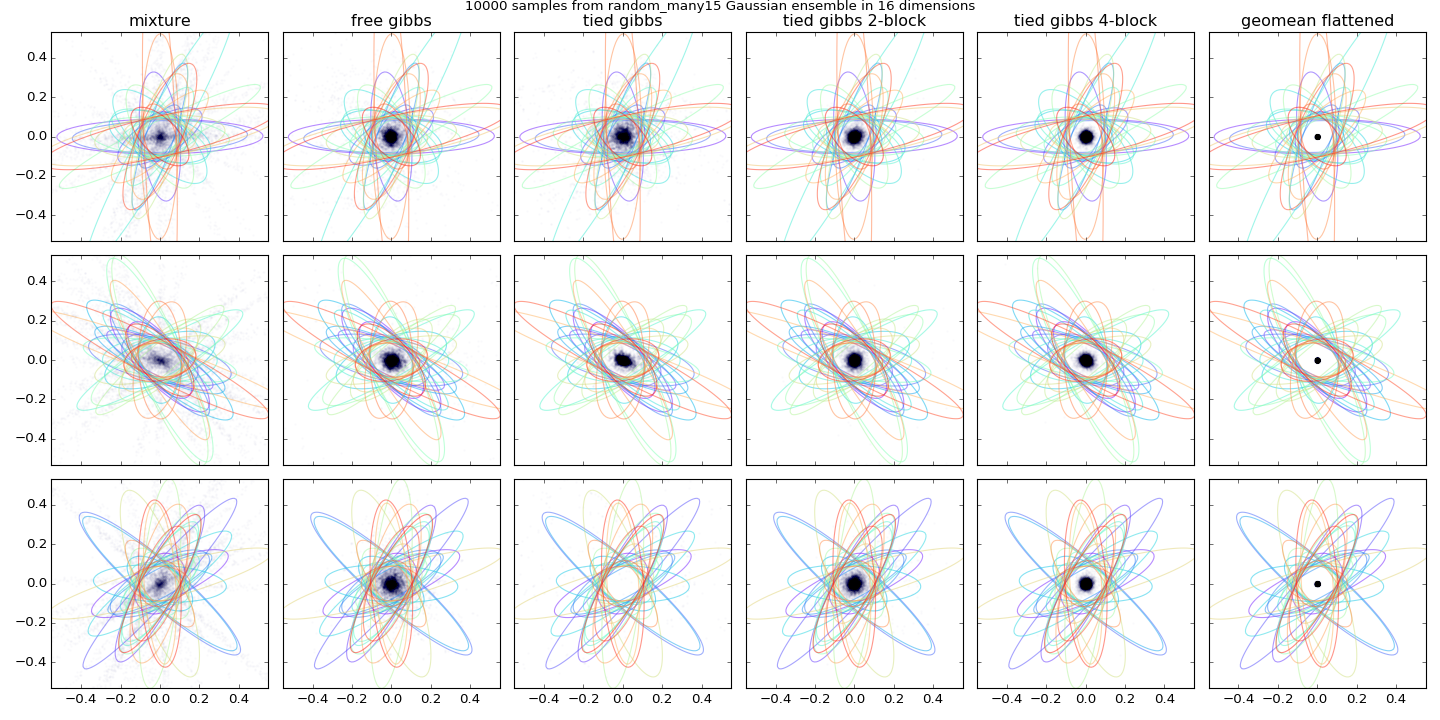

In [ ]:
def do_the_thing():
    plt.close("all")
    cached_samples = dict()

    # to ensure random models correspond to cached_samples
    np.random.seed(1)

    ndim = 16
    nsamples=10000
    ntrials = 3
    ddf = 15

    ensemble_generators = dict(random=ft.partial(get_random_models, ddf=ddf),
                               random_many=ft.partial(get_random_models, ddf=ddf, nmodels=2*ndim),
                               random_manymany=ft.partial(get_random_models, ddf=ddf, nmodels=4*ndim),
                               full_random=get_full_random_models,
                               orthogonal=get_orthogonal_models,
                               axial=get_axial_models)
    ensemble_kind = "random_many"

    ensembles = [ensemble_generators[ensemble_kind](ndim) for _ in range(ntrials)]
    projections = get_random_projections(ndim, nproj=ntrials)

    for trial in range(ntrials):
        print "trial", trial

        models = ensembles[trial]
        dimensions = get_canonical_basis(ndim)

        picker = IndependentPicker(RandomSubsetPicker(dimensions, k=1),
                                   RandomElementPicker(models))
        tied_picker = TiedPicker(dimensions, models)
        tied_picker2 = TiedPicker(dimensions, models, k=2)
        tied_picker4 = TiedPicker(dimensions, models, k=4)

        samplers = ordict([("mixture", sample_mixture),
                           ("free gibbs", ft.partial(sample_gibbs, picker=picker)),
                           ("tied gibbs", ft.partial(sample_gibbs, picker=tied_picker)),
                           ("tied gibbs 2-block", ft.partial(sample_gibbs, picker=tied_picker2)),
                           ("tied gibbs 4-block", ft.partial(sample_gibbs, picker=tied_picker4)),
                           ("geomean flattened", ft.partial(sample_geomean_root, root=ndim)),
                           #("geomean", sample_geomean),
                          ])

        for sampler, fn in samplers.items():
            print "sampler", sampler

            key = (trial, sampler)
            if "geomean" in sampler:
                try:
                    del cached_samples[key]
                except:
                    pass
            if (key not in cached_samples or
                len(cached_samples[key]) != nsamples
                or len(cached_samples[key][0]) != ndim):
                cached_samples[key] = fn(models=models, nsamples=nsamples)
    samples = cached_samples

    fig, axes = plt.subplots(ntrials, len(samplers),
                             sharex=True, sharey=True,
                             figsize=(len(samplers) * 3, ntrials * 3))

    # -_________________________-
    if ntrials == 1:
        axes = [axes]
    if len(samplers) == 1:
        axes = [[ax] for ax in axes]

    for trial, models, projection, row in zip(range(ntrials), ensembles, projections, axes):
        for sampler, ax in zip(samplers, row):
            plot_projected(ax, projection, models=models, samples=samples[(trial, sampler)])
            if trial == 0:
                ax.set_title(sampler)
            ax.set(xbound=(-0.5, 0.5))
            ax.set(ybound=(-0.5, 0.5))
            ax.set(aspect="equal")

    # zzz groan
    true_ensemble_kind = "%s%s" % (ensemble_kind, ddf if "random" in ensemble_kind else "")

    fig.suptitle("%i samples from %s Gaussian ensemble in %i dimensions" % (nsamples, true_ensemble_kind, ndim), y=1.00)
    plt.tight_layout()
    #plt.show()
    plt.savefig("ensample_k%s_n%i_d%i.png" % (true_ensemble_kind, nsamples, ndim), bbox_inches="tight")

do_the_thing()

# Debugging leftovers

In [ ]:
# show axis-aligned projections of one trial for debugging
def do_the_thing():
    plt.close("all")

    ndim = 4
    nsamples=10000
    ntrials = 3

    #ensembles = [get_random_models(ndim) for _ in range(ntrials)]
    ensembles = [get_axial_models(ndim) for _ in range(ntrials)]
    #projections = get_random_projections(ndim, nproj=ntrials)
    projections = get_canonical_projections(ndim)

    samples = dict()

    for trial in range(ntrials):
        print "trial", trial

        models = ensembles[trial]
        dimensions = get_canonical_basis(ndim)

        picker = IndependentPicker(RandomSubsetPicker(dimensions, k=1),
                                   RandomElementPicker(models))
        tied_picker = TiedPicker(dimensions, models)
        tied_picker2 = TiedPicker(dimensions, models, k=2)
        tied_picker4 = TiedPicker(dimensions, models, k=4)

        samplers = ordict([("mixture", sample_mixture),
                           ("free gibbs", ft.partial(sample_gibbs, picker=picker)),
                           ("tied gibbs", ft.partial(sample_gibbs, picker=tied_picker)),
                           ("tied gibbs 2-block", ft.partial(sample_gibbs, picker=tied_picker2)),
                           #("tied gibbs 4-block", ft.partial(sample_gibbs, picker=tied_picker4)),
                           ("geomean flattened", ft.partial(sample_geomean_root, root=ndim)),
                           ("geomean", sample_geomean),
                          ])

        for sampler, fn in samplers.items():
            print "sampler", sampler

            key = (trial, sampler)
            samples[key] = fn(models=models, nsamples=nsamples)

    fig, axes = plt.subplots(ntrials * len(projections), len(samplers),
                             sharex=True, sharey=True,
                             figsize=(len(samplers) * 2, ntrials * len(projections) * 2))

    # -_________________________-
    if ntrials * len(projections) == 1:
        axes = [axes]
    if len(samplers) == 1:
        axes = [[ax] for ax in axes]

    for ((trial, models), projection), row in zip(it.product(zip(range(ntrials), ensembles), projections), axes):
        print "plotting trial", trial, "projection", projection
        for sampler, ax in zip(samplers, row):
            plot_projected(ax, projection, models=models, samples=samples[(trial, sampler)])
            if trial == 0:
                ax.set_title(sampler)
            ax.set(xbound=(-0.5, 0.5))
            ax.set(ybound=(-0.5, 0.5))
            ax.set(aspect="equal")
    fig.suptitle("%i samples from Gaussian ensemble in %i dimensions" % (nsamples, ndim), y=1.00)

    if False:
        for i, direction in enumerate(get_canonical_basis(ndim)):
            plt.figure()
            plt.hist(np.dot(samples[(0, "free gibbs")], direction), bins=100, range=(-3, 3))
            plt.title(str(i))

        print "plotting %s pick stats" % sampler
        for (cond, model), samples in pick_stats.items():
            cond = np.fromstring(cond)
            model_axis = int(np.argmax(model.eigenvalues))
            assert len(cond) == 4
            cond_axis = int(np.argmax(cond))
            if cond_axis != 0:
                continue
            for i, direction in enumerate(get_canonical_basis(ndim)):
                if i not in [1, 2]:
                    continue
                if i == cond_axis:
                    continue
                plt.figure()
                plt.hist(np.asarray(samples)[:, i], bins=100, range=(-3, 3))
                plt.title("axis %i model axis %i cond axis %i" % (i, model_axis, cond_axis))

    plt.tight_layout()
    plt.show()

do_the_thing()

In [ ]:
def do_the_thing():
    plt.close("all")

    ndim = 4
    nsamples = 10000

    projections = get_canonical_projections(ndim)

    models = get_axial_models(ndim)

    # FIXME bug if pred[0] is model main axis
    # then it samples wide on pred[1] instead of pred[0]
    # NOTE fixed, bug was caused by dot(evecs.T, evals, evecs) instead of dot(evecs, evals, evecs.T) in some places

    cond = np.eye(ndim)[[0]]
    #pred = projection_complement(cond)
    #print "pred", pred
    pred = np.eye(ndim)[[1, 2, 3]] # bug
    pred = np.eye(ndim)[[1, 3, 2]] # bug
    #pred = np.eye(ndim)[[2, 1, 3]]
    #pred = np.eye(ndim)[[2, 3, 1]]
    #pred = np.eye(ndim)[[3, 1, 2]]
    #pred = np.eye(ndim)[[3, 2, 1]]
    value = np.zeros(ndim)

    unconditioned_model, = [model for model in models if int(np.argmax(model.eigenvalues)) == 1]
    conditioned_model = unconditioned_model.conditional(value, cond=cond, pred=pred)

    unconditioned_samples = np.asarray([unconditioned_model.sample() for _ in range(nsamples)])
    conditioned_samples_ = np.asarray([conditioned_model.sample() for _ in range(nsamples)])
    conditioned_samples = (np.dot(conditioned_samples_, pred) +
                           np.dot(cond.T, np.dot(cond, value)))

    print conditioned_model.eigenvalues
    print conditioned_model.eigenvectors

    for projection in projections:
        plt.figure()
        ax = plt.gca()
        plot_projected(ax, projection, models=[unconditioned_model], samples=unconditioned_samples)
        ax.set(xbound=(-0.5, 0.5))
        ax.set(ybound=(-0.5, 0.5))
        ax.set(aspect="equal")
        ax.set_title("unconditioned samples %s" % projection)

    for projection in projections:
        plt.figure()
        ax = plt.gca()
        plot_projected(ax, projection, models=[unconditioned_model], samples=conditioned_samples)
        ax.set(xbound=(-0.5, 0.5))
        ax.set(ybound=(-0.5, 0.5))
        ax.set(aspect="equal")
        ax.set_title("conditioned samples %s" % projection)

    for i in range(len(conditioned_samples_[0])):
        plt.figure()
        plt.hist(conditioned_samples_[:, i])
        plt.title("conditioned samples, direction %s" % pred[i])

    plt.tight_layout()
    plt.show()

do_the_thing()